# Introduction

Data Cleaning / quick EDA

# Notes

1. 1 missing value in `Award Date`
- For now: Will assume it's okay to drop this row of data

# Setup

In [179]:
# Enable autoreload for Python modules (e.g., scripts in the utils folder)
%load_ext autoreload
%autoreload 2

# === Standard Library Imports ===
import json
import os
import sys
from pathlib import Path

# === Third-Party Library Imports ===
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
# import numpy as np (not used)
import pandas as pd
import seaborn as sns

# === Local Project-Specific Imports ===
# Add project root to the Python path
root_path = os.path.abspath("../")
if root_path not in sys.path:
    sys.path.append(root_path)

from src.utils import load_yaml, to_snake_case, clean_column_names, Timer

# Load environment variables from .env
from dotenv import load_dotenv
load_dotenv();

# Configure display options
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_rows', 20)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
# Start timer
timer = Timer()

# Load config

In [181]:
config = load_yaml("../config/data.yaml")

print(json.dumps(config, indent=4))

{
    "base_path": "../",
    "paths": {
        "raw_data": "data/00_raw/",
        "clean_data": "data/01_clean/",
        "output_data": "data/02_output/",
        "other_data": "data/99_other/"
    },
    "data": {
        "raw": {
            "path": "Quant_Take_Home.xlsx",
            "sheet": "Pipeline Data",
            "columns": {
                "Business Unit": "str",
                "Account Name": "str",
                "Opportunity Number": "int64",
                "Forecast Category": "str",
                "Award Date": "datetime64[ns]",
                "Revenue Amount": "float64",
                "Stage": "str",
                "Probability of Award": "float64",
                "Weighted Revenue Amount": "float64",
                "Type": "str",
                "Revenue Type": "str",
                "Revenue Year": "int64"
            }
        },
        "clean": {
            "path": "20250423_cleaned_data.csv",
            "columns": {
                "business_uni

# Pull data

In [182]:
# Build full path to the Excel file
base_path = Path(config["base_path"])
raw_data_path = base_path / config["paths"]["raw_data"]
excel_file = raw_data_path / config["data"]["raw"]["path"]
sheet_name = config["data"]["raw"]["sheet"]
print("Excel file:", excel_file)
print("Sheet name:", sheet_name)

# === Load Excel sheet ===
df = pd.read_excel(excel_file, sheet_name=sheet_name)
print(df.shape)

df.head()

Excel file: ../data/00_raw/Quant_Take_Home.xlsx
Sheet name: Pipeline Data
(1310, 12)


,Business Unit,Account Name,Opportunity Number,Forecast Category,Award Date,Revenue Amount,Stage,Probability of Award,Weighted Revenue Amount,Type,Revenue Type,Revenue Year
0,Maritime,Prometheus Defense Innovations,71201,Base Case,2029-08-25 00:00:00,195836453,Shaping,0.9023,1.767032e+08,Follow-On,O&M,2029
1,Radars,Inferno Protection Tech,31305,Base Case,2029-11-04 00:00:00,114991405,Shaping,0.9023,1.037567e+08,New Business,Product,2029
2,Solid Rocket Motors,Vortex Security Dynamics,30977,Base Case,2029-11-29 00:00:00,151129327,Shaping,0.9023,1.363640e+08,New Business,O&M,2029
3,Command and Control,Maelstrom Defense Group,75064,Base Case,2029-02-20 00:00:00,195003733,Shaping,0.7725,1.506404e+08,Follow-On,Product,2029
4,Command and Control,Vanguard Tactical Solutions,32256,Base Case,12/14/2029,23139092,Shaping,0.2430,5.622799e+06,New Business,Development,2029


# Quick Checks

In [183]:
print(df.columns)

Index(['Business Unit ', 'Account Name', 'Opportunity Number ',
       'Forecast Category', 'Award Date', 'Revenue Amount', 'Stage',
       'Probability of Award', 'Weighted Revenue Amount', 'Type',
       'Revenue Type ', 'Revenue Year '],
      dtype='object')


In [184]:
# Quickly remove any whitespace from the column names ie. use .strip()
df.columns = df.columns.str.strip()
print(df.columns)

Index(['Business Unit', 'Account Name', 'Opportunity Number',
       'Forecast Category', 'Award Date', 'Revenue Amount', 'Stage',
       'Probability of Award', 'Weighted Revenue Amount', 'Type',
       'Revenue Type', 'Revenue Year'],
      dtype='object')


In [185]:
print(df.dtypes)

Business Unit               object
Account Name                object
Opportunity Number           int64
Forecast Category           object
Award Date                  object
Revenue Amount               int64
Stage                       object
Probability of Award       float64
Weighted Revenue Amount    float64
Type                        object
Revenue Type                object
Revenue Year                 int64
dtype: object


In [186]:
# Assert that each column name has been read in as the correct type (as in the config file)
for col, expected_type in config["data"]["raw"]["columns"].items():
    if col in df.columns:
        if expected_type == "datetime64[ns]":
            df[col] = pd.to_datetime(df[col], errors="coerce")
        elif expected_type == "str":
            df[col] = df[col].astype("string")
        else:
            df[col] = df[col].astype(expected_type, errors="ignore")
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

print(df.dtypes)

Business Unit              string[python]
Account Name               string[python]
Opportunity Number                  int64
Forecast Category          string[python]
Award Date                 datetime64[ns]
Revenue Amount                    float64
Stage                      string[python]
Probability of Award              float64
Weighted Revenue Amount           float64
Type                       string[python]
Revenue Type               string[python]
Revenue Year                        int64
dtype: object


In [187]:
# Ensure top/bottom align with what you see in Excel
df.head(5)

,Business Unit,Account Name,Opportunity Number,Forecast Category,Award Date,Revenue Amount,Stage,Probability of Award,Weighted Revenue Amount,Type,Revenue Type,Revenue Year
0,Maritime,Prometheus Defense Innovations,71201,Base Case,2029-08-25,195836453.0,Shaping,0.9023,1.767032e+08,Follow-On,O&M,2029
1,Radars,Inferno Protection Tech,31305,Base Case,2029-11-04,114991405.0,Shaping,0.9023,1.037567e+08,New Business,Product,2029
2,Solid Rocket Motors,Vortex Security Dynamics,30977,Base Case,2029-11-29,151129327.0,Shaping,0.9023,1.363640e+08,New Business,O&M,2029
3,Command and Control,Maelstrom Defense Group,75064,Base Case,2029-02-20,195003733.0,Shaping,0.7725,1.506404e+08,Follow-On,Product,2029
4,Command and Control,Vanguard Tactical Solutions,32256,Base Case,2029-12-14,23139092.0,Shaping,0.2430,5.622799e+06,New Business,Development,2029


In [188]:
df.tail(5)

,Business Unit,Account Name,Opportunity Number,Forecast Category,Award Date,Revenue Amount,Stage,Probability of Award,Weighted Revenue Amount,Type,Revenue Type,Revenue Year
1305,Command and Control,Maelstrom Defense Group,91879,"Closed, Won",2027-01-30,101828350.0,Closed Won,1.0,101828350.0,New Business,Product,2027
1306,Counter-UAS,Patriot Defense Solutions,73769,"Closed, Won",2027-02-11,101297867.0,Closed Won,1.0,101297867.0,Modification,Development,2027
1307,Radars,Blitzkrieg Defense Innovations,26660,"Closed, Won",2027-01-13,99849344.0,Closed Won,1.0,99849344.0,Follow-On,Product,2027
1308,Maritime,Draco Armament Research,37957,"Closed, Won",2027-02-26,98916175.0,Closed Won,1.0,98916175.0,Modification,Product,2027
1309,Unmanned Aerial Systems,Argus Defense Systems,41873,"Closed, Won",2027-02-05,96610340.0,Closed Won,1.0,96610340.0,New Business,Product,2027


In [189]:
# Check that in all rows, 'Revenue Amount' * 'Probability of Award' == 'Weighted Revenue Amount'
df['check'] = (df['Revenue Amount'] * df['Probability of Award'])
print((df['check'] == df['Weighted Revenue Amount']).value_counts(dropna=False))

df[['Revenue Amount', 'Probability of Award', 'Weighted Revenue Amount', 'check']].head(5)

True    1310
Name: count, dtype: int64


,Revenue Amount,Probability of Award,Weighted Revenue Amount,check
0,195836453.0,0.9023,1.767032e+08,1.767032e+08
1,114991405.0,0.9023,1.037567e+08,1.037567e+08
2,151129327.0,0.9023,1.363640e+08,1.363640e+08
3,195003733.0,0.7725,1.506404e+08,1.506404e+08
4,23139092.0,0.2430,5.622799e+06,5.622799e+06


In [190]:
# Drop the check column, as it's not needed
if 'check' in df.columns:
    df.drop(columns=['check'], inplace=True)

# Quick EDA

In [191]:
# Print value counts for each column
for col in df.columns:
    print(f"Value counts for '{col}':")
    print(df[col].value_counts(dropna=False))
    print("------------------------------------------------ \n\n")

Value counts for 'Business Unit':
Business Unit
Maritime                   192
Command and Control        192
Radars                     191
Unmanned Aerial Systems    186
Counter-UAS                185
Counter-Intrusion          184
Solid Rocket Motors        180
Name: count, dtype: Int64
------------------------------------------------ 


Value counts for 'Account Name':
Account Name
Jupiter Defense Platform         14
Aegis Cyber Solutions            14
Valkyrie Defense Technologies    14
Manticore Aerospace Tech         14
Spartan Tactical Technologies    14
                                 ..
Kraken Maritime Defense          12
Nomad Intelligence Systems       11
Triton Naval Technologies        11
Nova Intel Systems               11
Minerva Intelligence Systems     10
Name: count, Length: 98, dtype: Int64
------------------------------------------------ 


Value counts for 'Opportunity Number':
Opportunity Number
71201    1
39456    1
53239    1
26760    1
79838    1
        ..
5

# Clean data

In [192]:
# Drop the 1 row of data where 'Award Date' is np.nan
count_nan = df['Award Date'].isna().sum()
if count_nan > 0:
    print(f"Dropping {count_nan} rows with NaN in 'Award Date' column.")
    df.dropna(subset=['Award Date'], inplace=True)
    print(f"Dropped {count_nan} rows with NaN in 'Award Date' column.")

Dropping 1 rows with NaN in 'Award Date' column.
Dropped 1 rows with NaN in 'Award Date' column.


In [193]:
# === Clean the data ===
df = clean_column_names(df)

In [194]:
df.columns

Index(['business_unit', 'account_name', 'opportunity_number',
       'forecast_category', 'award_date', 'revenue_amount', 'stage',
       'probability_of_award', 'weighted_revenue_amount', 'type',
       'revenue_type', 'revenue_year'],
      dtype='object')

# Basic EDA

In [195]:
# === Basic EDA ===
print("✅ Data Loaded")
print("Shape:", df.shape)
print("\n🧾 Info:")
df.info()

print("\nMissing values:")
print(df.isnull().sum())

print("\nDescribe (Numerics):")
print(df.describe())

print("\nDescribe (All Types):")
print(df.describe(include='all'))

✅ Data Loaded
Shape: (1309, 12)

🧾 Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 1309
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   business_unit            1309 non-null   string        
 1   account_name             1309 non-null   string        
 2   opportunity_number       1309 non-null   int64         
 3   forecast_category        1309 non-null   string        
 4   award_date               1309 non-null   datetime64[ns]
 5   revenue_amount           1309 non-null   float64       
 6   stage                    1309 non-null   string        
 7   probability_of_award     1309 non-null   float64       
 8   weighted_revenue_amount  1309 non-null   float64       
 9   type                     1309 non-null   string        
 10  revenue_type             1309 non-null   string        
 11  revenue_year             1309 non-null   int64         
dty

# More EDA

Not aware of response variable, so will start with just univariate analysis to understand the distributions, ranges, and potential outliers in each feature

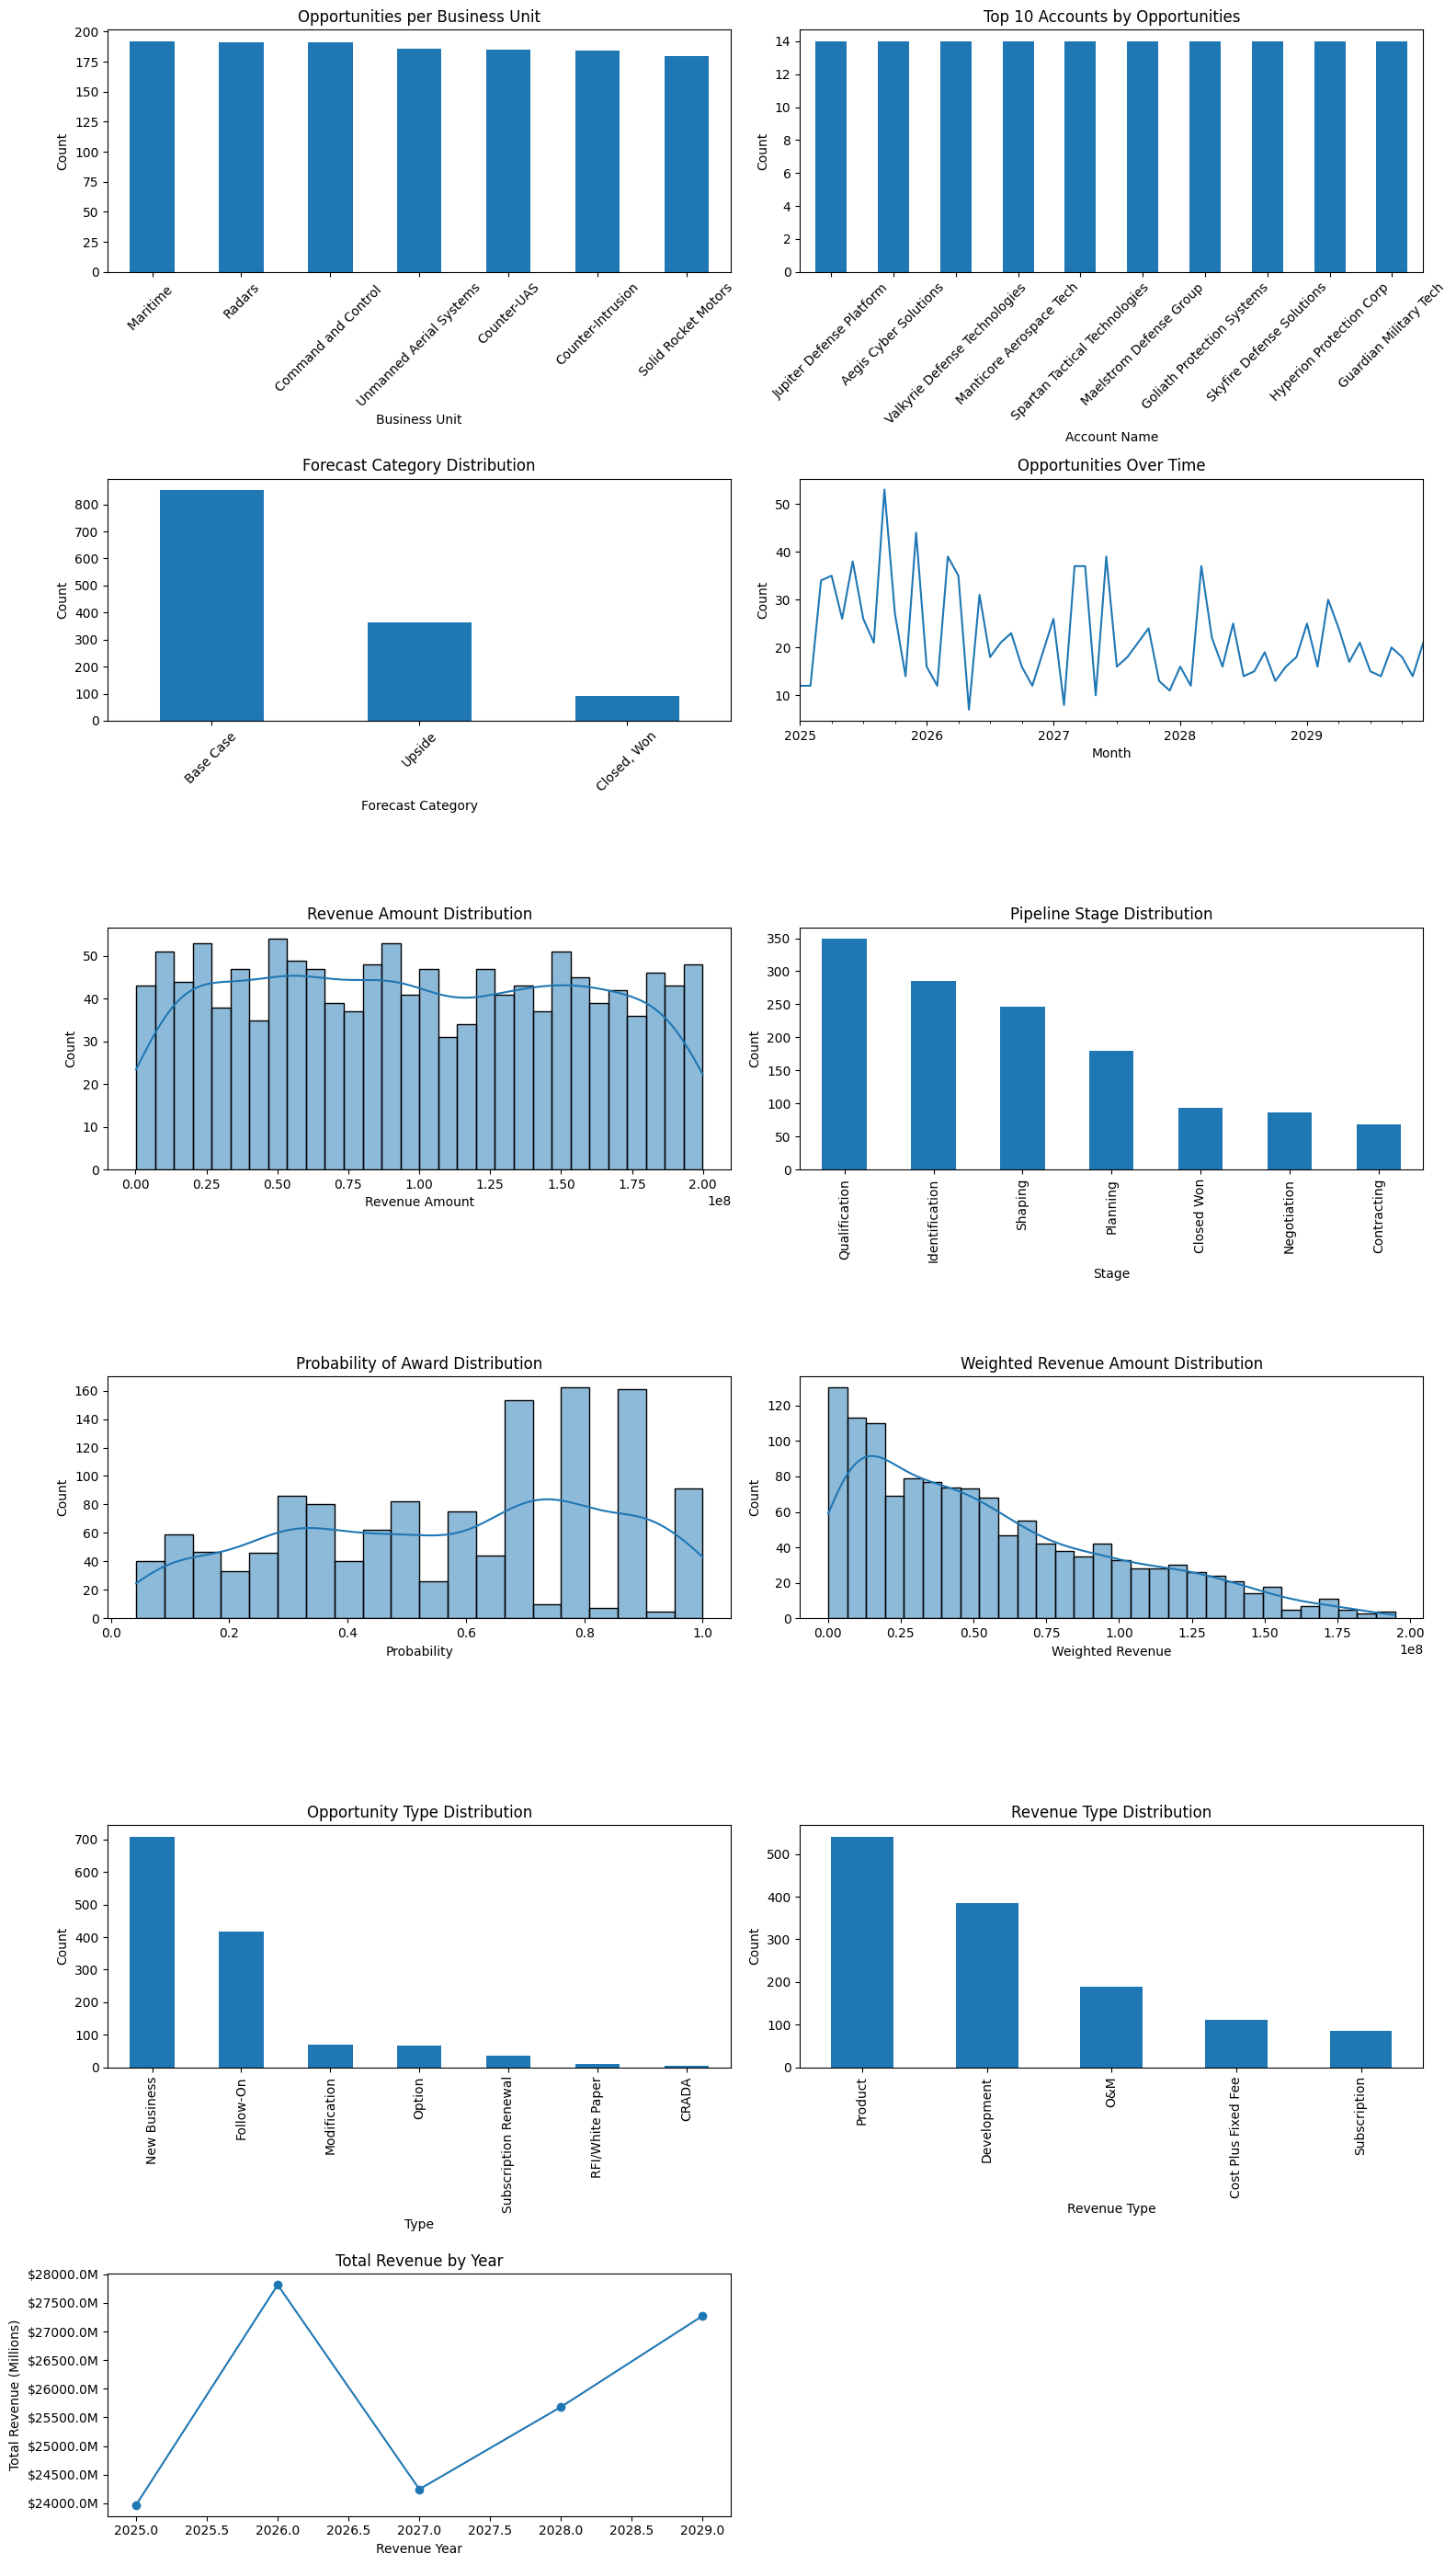

In [196]:
plt.figure(figsize=(16, 28))

# 1. business_unit - Count of opportunities
plt.subplot(6, 2, 1)
df['business_unit'].value_counts().plot(kind='bar')
plt.title("Opportunities per Business Unit")
plt.xlabel("Business Unit")
plt.ylabel("Count")
plt.xticks(rotation=45)

# 2. account_name - Top 10 accounts by opportunity count
plt.subplot(6, 2, 2)
df['account_name'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Accounts by Opportunities")
plt.xlabel("Account Name")
plt.ylabel("Count")
plt.xticks(rotation=45)

# 3. forecast_category - Distribution
plt.subplot(6, 2, 3)
df['forecast_category'].value_counts().plot(kind='bar')
plt.title("Forecast Category Distribution")
plt.xlabel("Forecast Category")
plt.ylabel("Count")
plt.xticks(rotation=45)

# 4. award_date - Opportunities over time
plt.subplot(6, 2, 4)
df['award_date'].dt.to_period("M").value_counts().sort_index().plot()
plt.title("Opportunities Over Time")
plt.xlabel("Month")
plt.ylabel("Count")

# 5. revenue_amount - Distribution
plt.subplot(6, 2, 5)
sns.histplot(df['revenue_amount'], bins=30, kde=True)
plt.title("Revenue Amount Distribution")
plt.xlabel("Revenue Amount")

# 6. stage - Count by stage
plt.subplot(6, 2, 6)
df['stage'].value_counts().plot(kind='bar')
plt.title("Pipeline Stage Distribution")
plt.xlabel("Stage")
plt.ylabel("Count")

# 7. probability_of_award - Distribution
plt.subplot(6, 2, 7)
sns.histplot(df['probability_of_award'], bins=20, kde=True)
plt.title("Probability of Award Distribution")
plt.xlabel("Probability")

# 8. weighted_revenue_amount - Distribution
plt.subplot(6, 2, 8)
sns.histplot(df['weighted_revenue_amount'], bins=30, kde=True)
plt.title("Weighted Revenue Amount Distribution")
plt.xlabel("Weighted Revenue")

# 9. type - Distribution
plt.subplot(6, 2, 9)
df['type'].value_counts().plot(kind='bar')
plt.title("Opportunity Type Distribution")
plt.xlabel("Type")
plt.ylabel("Count")

# 10. revenue_type - Distribution
plt.subplot(6, 2, 10)
df['revenue_type'].value_counts().plot(kind='bar')
plt.title("Revenue Type Distribution")
plt.xlabel("Revenue Type")
plt.ylabel("Count")

# 11. revenue_year - Revenue per year in millions
plt.subplot(6, 2, 11)
ax = df.groupby("revenue_year")["revenue_amount"].sum().plot(marker='o')
plt.title("Total Revenue by Year")
plt.xlabel("Revenue Year")
plt.ylabel("Total Revenue (Millions)")

# Format y-axis ticks as millions
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

# Export Data

In [197]:
# Write down dtypes so you can just read them in later like this
print(df.dtypes)

business_unit              string[python]
account_name               string[python]
opportunity_number                  int64
forecast_category          string[python]
award_date                 datetime64[ns]
revenue_amount                    float64
stage                      string[python]
probability_of_award              float64
weighted_revenue_amount           float64
type                       string[python]
revenue_type               string[python]
revenue_year                        int64
dtype: object


In [198]:
# Export to a CSV for use in other notebooks
clean_data_path = base_path / config["paths"]["clean_data"]
df.to_csv(clean_data_path / config["data"]["clean"]["path"], index=False)

print(f"Data Cleaned and Exported to {clean_data_path / config['data']['clean']['path']}")

Data Cleaned and Exported to ../data/01_clean/20250423_cleaned_data.csv


In [199]:
# Stop timer
timer.stop()

Elapsed time: 0 minutes and 1 seconds
